In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/FDL21_RaVAEn_datasets/floods.zip" floods.zip
!unzip floods.zip
!rm floods.zip

Archive:  floods.zip
   creating: floods/
   creating: floods/EMSR333_02PORTOPALO/
   creating: floods/EMSR333_02PORTOPALO/changes_vector/
  inflating: floods/EMSR333_02PORTOPALO/changes_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/S2/
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-25.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-20.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-23.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-30.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/
  inflating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/changes/
  inflating: floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/floodmap_edited/
  inflating: floods/EMSR333_02PORTOPALO/floodmap_edited/2018-11-04.geojson  
   creating: floods/EMSR271_02FARKADONA/
  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
import rasterio

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class FloodDataset(nn.Module):
    def __init__(self, patch_size=64):
        super(FloodDataset, self).__init__()
        self.patch_size = patch_size
        self.patches = []
        self.precompute_patches()

    def precompute_patches(self):
        root = os.listdir("floods")
        for path in root:
            img_paths = [os.path.join("floods", path, "S2", x) for x in os.listdir(os.path.join("floods", path, "S2")) if x.endswith(".tif")]
            for img_path in img_paths:
                with rasterio.open(img_path) as src:
                    img = src.read()  # Read all bands
                height, width = img.shape[1], img.shape[2]
                for row in range(0, height, self.patch_size):
                    for col in range(0, width, self.patch_size):
                        if row + self.patch_size <= height and col + self.patch_size <= width:
                            patch = img[:, row:row + self.patch_size, col:col + self.patch_size]
                            quantiles = np.quantile(patch, [0.01, 0.99], axis=(1, 2), keepdims=True)
                            patch = (patch - quantiles[0]) / (quantiles[1] - quantiles[0]+1e-5)
                            patch = np.clip(patch, 0,1)
                            patch = torch.tensor(patch, dtype=torch.float32)
                            if not torch.isnan(patch).any():
                                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [3]:
ds = FloodDataset(patch_size=256)

split = 0.8
train_size = int(split * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)



torch.Size([32, 15, 256, 256])


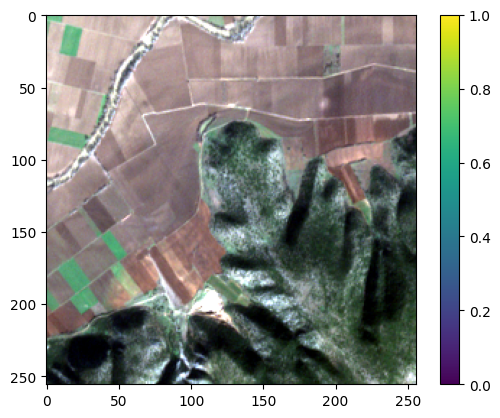

In [4]:
#Test train_loader
bands = [3,2,1]
data = next(iter(train_loader))
print(data.shape)
plt.imshow(data[0,bands,:,:].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, stride=2, padding=1),  # 4 input channels (
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 input channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64 input channels
            nn.ReLU())
        self.fc_mu = nn.Linear(128 * 8 * 8 *16, self.latent_size)
        self.fc_logvar = nn.Linear(128 * 8 * 8 * 16, self.latent_size)
        self.fc_decode = nn.Linear(self.latent_size, 128 * 8 * 8*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # 128 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 15, kernel_size=8, stride=2, padding=1),  # 32 input channels
            nn.Sigmoid())
        # 4 output channels (same as input)

    def encode(self, x):
        # Define the encoder part of the VAE
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 8*4, 8*4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        # Forward pass through the VAE
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [6]:
def loss_function(recon_x, x, mu, logvar, gamma):
    # Define the loss function for the VAE
    # Gamma is the variance of the prior
    D = mu.size(1)
    MSE = D*(F.mse_loss(recon_x, x, reduction='sum')/(2*gamma.pow(2)) + (gamma.log()))
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)
    return MSE , KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, gamma, optimizer, epochs):
    t_mse = []
    t_kld = []
    v_mse = []
    v_kld = []

    for epoch in range(epochs):
        model.train()
        train_loss_mse = 0
        train_loss_kld = 0
        train_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
            loss = mse + kld
            train_loss_kld += kld.item()
            train_loss_mse += mse.item()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Append train losses to lists after each epoch
        t_mse.append(train_loss_mse / len(train_loader.dataset))
        t_kld.append(train_loss_kld / len(train_loader.dataset))

        print(f"====> Epoch: {epoch} Average loss: {(train_loss) / len(train_loader.dataset):.4f}")

        val_loss_mse = 0
        val_loss_kld = 0
        val_loss = 0
        for batch_idx ,data in enumerate(val_loader):
            model.eval()
            data = data.to(device)
            with torch.no_grad():
                recon_batch, mu, logvar = model(data)
                mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
                v_loss = mse + kld
                val_loss_kld += kld.item()
                val_loss_mse += mse.item()
                val_loss += v_loss.item()
        # Append val losses to lists after each epoch
        v_mse.append(val_loss_mse / len(val_loader.dataset))
        v_kld.append(val_loss_kld / len(val_loader.dataset))

        print(f"====> Validation loss: {(val_loss) / len(val_loader.dataset):.4f}")

    return t_mse, t_kld, v_mse, v_kld

In [ ]:
model = VAE(latent_size=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = torch.tensor([1]).to(device)
optimizer.add_param_group({'params': gamma})
train(model, train_loader, val_loader, gamma, optimizer, epochs=100)

16it [00:05,  2.78it/s]


====> Epoch: 0 Average loss: 15392480.3125
====> Validation loss: 12913390.2500


16it [00:05,  3.07it/s]


====> Epoch: 1 Average loss: 12889557.8125
====> Validation loss: 12494639.2500


16it [00:03,  4.07it/s]

====> Epoch: 2 Average loss: 12420306.0625


====> Validation loss: 11960236.0000


16it [00:03,  4.60it/s]

====> Epoch: 3 Average loss: 11826057.8750


====> Validation loss: 11612884.7500


16it [00:04,  3.51it/s]


====> Epoch: 4 Average loss: 11330467.0625
====> Validation loss: 11015196.2500


16it [00:03,  4.57it/s]

====> Epoch: 5 Average loss: 10690652.0000


====> Validation loss: 10439825.7500


16it [00:03,  4.47it/s]

====> Epoch: 6 Average loss: 9899297.0000


====> Validation loss: 9611293.2500


16it [00:04,  3.84it/s]

====> Epoch: 7 Average loss: 9109168.0625


====> Validation loss: 9100606.5000


16it [00:03,  4.46it/s]

====> Epoch: 8 Average loss: 8456341.5312


====> Validation loss: 8823588.5000


16it [00:03,  4.45it/s]

====> Epoch: 9 Average loss: 7924514.0938


====> Validation loss: 8273182.8750


16it [00:04,  3.71it/s]

====> Epoch: 10 Average loss: 7391930.0625


====> Validation loss: 7828518.5000


16it [00:03,  4.48it/s]

====> Epoch: 11 Average loss: 6939528.4688


====> Validation loss: 7483584.1250


16it [00:03,  4.16it/s]

====> Epoch: 12 Average loss: 6361863.0000


====> Validation loss: 7051429.8750


16it [00:04,  3.71it/s]

====> Epoch: 13 Average loss: 5763568.2188


====> Validation loss: 6515150.8750


11it [00:02,  4.54it/s]

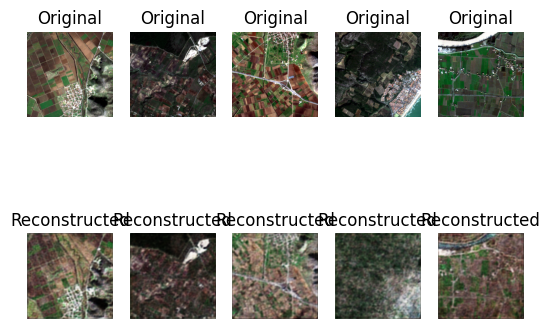

In [ ]:
data = next(iter(val_loader))

data = data.to(device)
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.cpu().detach().numpy()
data = data.cpu().detach().numpy()

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon_batch[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()



In [ ]:
torch.cuda.empty_cache()
mu, logvar = model.encode(torch.Tensor(data[0:1]).to(device))
import numpy as np
mu, logvar = mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()
# Generate batch without ablation
z_no_ablation = np.random.normal(loc=mu, scale=np.exp(logvar), size=(500,128))

recon_no_ablation = model.decode(torch.Tensor(z_no_ablation).to(device))
recon_no_ablation = recon_no_ablation.cpu().detach().numpy()

# Generate batch with ablation
z_ablation = torch.Tensor(z_no_ablation).clone()
z_ablation[:, 64:127] = 0
z_ablation = z_ablation.to(device)
recon_ablation = model.decode(z_ablation)
recon_ablation = recon_ablation.cpu().detach().numpy()


err_map = np.var(data[0:1] - recon_no_ablation, axis=0)
err_map = np.mean(err_map, axis=0)

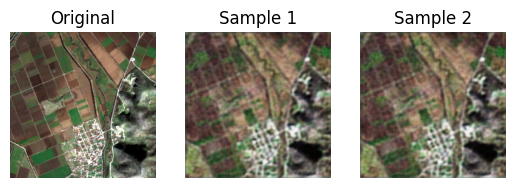

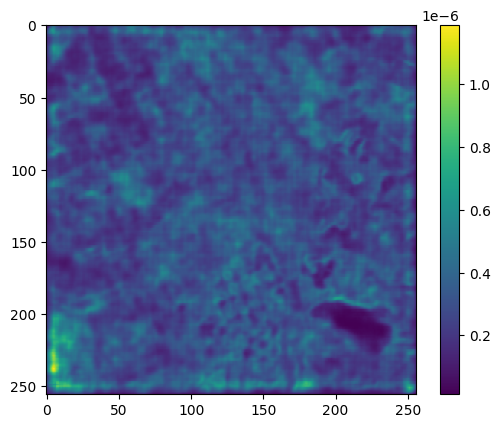

In [ ]:
plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_no_ablation[1,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 2")
plt.axis('off')

plt.show()

plt.imshow(err_map)
plt.colorbar()
plt.show()